## Deep Generative Models: Variational Autoencoders
### Seminar in Artificial Intelligence
#### Markus Böck

In [1]:
%load_ext autoreload
%autoreload 2

### PyTorch

In [2]:
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

We consider two image data sets:

- MNIST: handwritten digits
- FashionMNIST: images of Zalando clothing articles 

In [21]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from utils import *

#### MNIST

In [6]:
MNIST_train_data = datasets.MNIST(root='data', train=True,
                                  transform=ToTensor(),
                                  download=True)
MNIST_test_data = datasets.MNIST(root='data', train=False,
                                 transform=ToTensor())

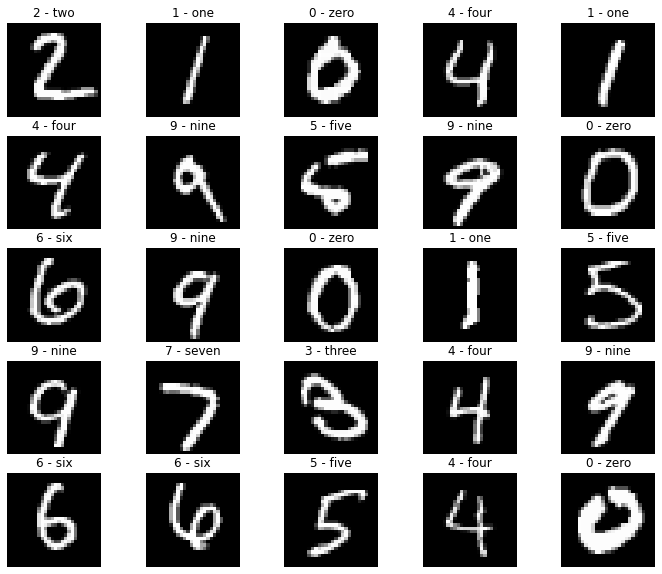

In [7]:
plot_batch_with_labels(MNIST_test_data, MNIST_test_data.classes)

#### FashionMNIST

In [8]:
FashionMNIST_train_data = datasets.FashionMNIST(root='data', train=True,
                                                transform=ToTensor(),
                                                download=True)
FashionMNIST_test_data = datasets.FashionMNIST(root='data', train=False,
                                               transform=ToTensor())

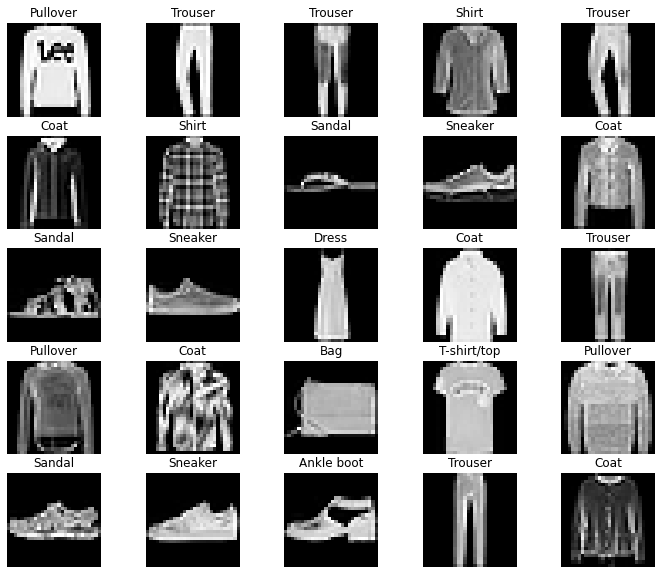

In [9]:
plot_batch_with_labels(FashionMNIST_test_data, FashionMNIST_test_data.classes)

In [10]:
from torch.utils.data import DataLoader

MNIST_loaders = {
    'train' : DataLoader(MNIST_train_data, batch_size=256, shuffle=True, num_workers=4, pin_memory=True),
    'test'  : DataLoader(MNIST_test_data, batch_size=256, shuffle=True, num_workers=4, pin_memory=True),
}
MNIST_test_batch_x, MNIST_test_batch_y = get_batch(MNIST_test_data, 26, device)


FashionMNIST_loaders = {
    'train' : DataLoader(FashionMNIST_train_data, batch_size=256, shuffle=True, num_workers=4, pin_memory=True),
    'test'  : DataLoader(FashionMNIST_test_data, batch_size=256, shuffle=True, num_workers=4, pin_memory=True),
}
FashionMNIST_test_batch_x, FashionMNIST_test_batch_y = get_batch(FashionMNIST_test_data, 26, device)

In [11]:
import torch.nn as nn
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

In [50]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class EncoderZ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        
        # two heads for mean and std
        self.fc31 = nn.Linear(hidden_dims[1], output_dim)
        self.fc32 = nn.Linear(hidden_dims[1], output_dim)
        
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.softplus(self.fc1(x))
        x = self.softplus(self.fc2(x))
        
        # use two heads for mean and std
        z_loc = self.fc31(x)
        z_scale = torch.exp(self.fc32(x))
        return z_loc, z_scale

In [51]:
# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dims[1])
        self.fc2 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.fc3 = nn.Linear(hidden_dims[0], output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        z = self.softplus(self.fc1(z))
        z = self.softplus(self.fc2(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = torch.sigmoid(self.fc3(z))
        return loc_img

In [52]:
class VAE(nn.Module):
    def __init__(self, z_dim, hidden_dims, device, input_size=784):
        super().__init__()
        self.input_size = input_size
        self.z_dim = z_dim
        
        self.encoder = EncoderZ(input_size, z_dim, hidden_dims)
        self.decoder = Decoder(z_dim, input_size, hidden_dims)
        
        self.to(device)

    # define the model p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            
            # sample from prior p(z)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            loc_img = self.decoder.forward(z)
            
            # score against actual images
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img, validate_args=False).to_event(1),
                obs=x, # TODO
            )
            
            return loc_img

    # define the guide (variational distribution) q(z|x)
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            
            # sample the latent variable z from q(z|x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [61]:
def vae_reconstruct_imgs(vae, x):
    z_loc, z_scale = vae.encoder(x.reshape(-1, vae.input_size))
    z = dist.Normal(z_loc, z_scale).sample() # sample in latent space
    loc_img = vae.decoder(z)
    return loc_img

In [57]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

def train_VAE(loaders, vae, device, epochs=25, verbose=True, show_plot=True):
    optimizer = Adam({'lr': 1.0e-3})

    elbo = Trace_ELBO()
    svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

    train_elbo = []
    test_elbo = []
    
    for epoch in range(1, epochs+1):
        
        epoch_loss = 0.0
        for x, _ in loaders['train']:
            x = x.reshape(-1, vae.input_size).to(device)
            epoch_loss += svi.step(x)

        total_epoch_loss_train = epoch_loss / len(loaders['train'].dataset)
        train_elbo.append(total_epoch_loss_train)

        test_loss = 0.0
        for x, _ in loaders['test']:
            x = x.reshape(-1, vae.input_size).to(device)
            test_loss += svi.evaluate_loss(x)

        total_epoch_loss_test = test_loss / len(loaders['test'].dataset)
        test_elbo.append(total_epoch_loss_test)
        
        if verbose:
            print(f"Epoch {epoch:4d}: training loss: {total_epoch_loss_train:.4f} test loss: {total_epoch_loss_test:.4f}", end='\r')
    
    if show_plot:
        plt.plot(train_elbo, label='ELBO train')
        plt.plot(test_elbo, label='ELBO test')
        plt.xlabel('Epoch')
        plt.ylabel('ELBO')
        plt.legend()
        plt.show()

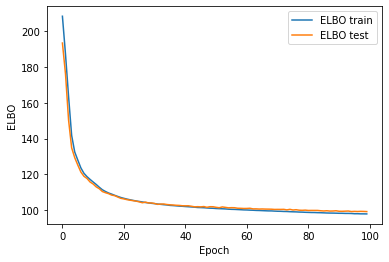

Wall time: 15min 1s


In [58]:
%%time
seed_everything()
pyro.clear_param_store()

loaders = MNIST_loaders
test_batch_x = MNIST_test_batch_x
test_batch_y = MNIST_test_batch_y
vae = VAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_VAE(loaders, vae, epochs=100, device=device)

Original Batch


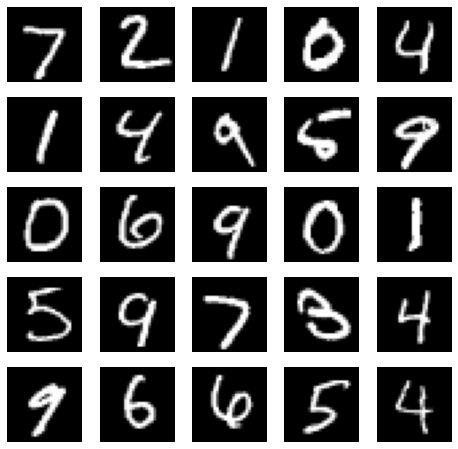

Reconstructed Batch


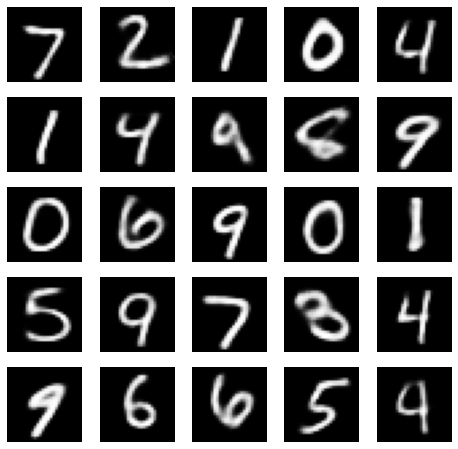

In [62]:
print('Original Batch')
plot_batch(test_batch_x.cpu(),figsize=(8, 8))

print('Reconstructed Batch')
reconstruced_x = vae_reconstruct_imgs(vae, test_batch_x)
plot_batch(reconstruced_x.cpu().detach().numpy().reshape((26, 1, 28, 28)), figsize=(8, 8))

In [63]:
def vae_sample_imgs(vae, n, device):
    z_loc = torch.zeros(n, vae.z_dim, device=device)
    z_scale = torch.ones(n, vae.z_dim, device=device)
    
    z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    imgs = vae.decoder.forward(z)
    return imgs

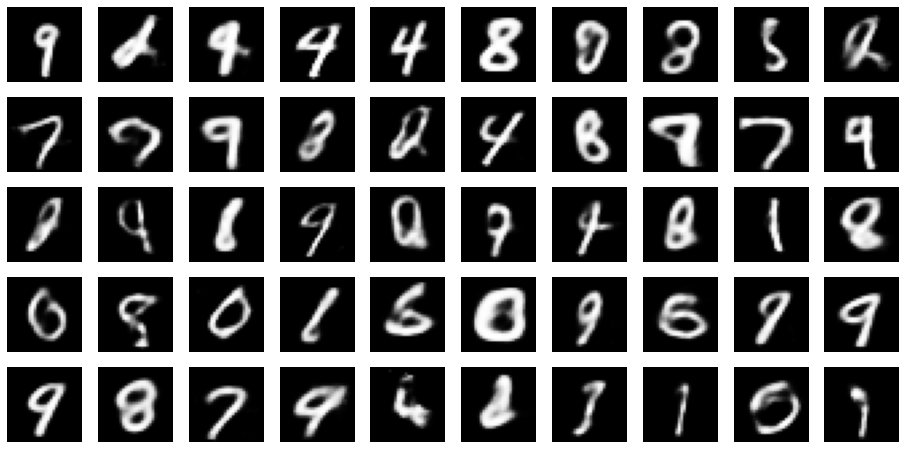

In [64]:
N = 50
sampled_x = vae_sample_imgs(vae, N, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))

In [65]:
class EncoderY(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)
        
        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, self.input_dim) # flatten input
        
        x = self.softplus(self.fc1(x))
        x = self.softplus(self.fc2(x))
        
        y = self.softmax(self.fc3(x)) # returns probabilities
        return y

In [77]:
class SSVAE(nn.Module):
    def __init__(self, z_dim, hidden_dims,  device, input_size=784, n_labels=10):
        super().__init__()
        
        self.z_dim = z_dim
        self.input_size = input_size
        self.output_size = n_labels
        
        self.concat = ConcatModule(allow_broadcast=True)
        self.encoder_z = EncoderZ(input_size + n_labels, z_dim, hidden_dims)
        self.encoder_y = EncoderY(input_size, n_labels, hidden_dims)
        
        self.decoder = Decoder(z_dim + n_labels, input_size, hidden_dims)
        
        self.to(device)

    # define the model p(x|y,z) p(y) p(z)
    def model(self, x, y=None):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            #print('model x', x.shape)
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            
            # sample from prior p(z)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            #print('model z', z.shape)
            
            # setup hyperparameters for prior p(y)
            alpha = torch.ones(x.shape[0], self.output_size, dtype=x.dtype, device=x.device) / (1.0 * self.output_size)
            #print('model alpha', alpha.shape)
            
            # sample from prior p(y)
            y = pyro.sample("y", dist.OneHotCategorical(alpha), obs=y)
            #print('model y', y.shape)
            
            # decode the latent code z
            loc_img = self.decoder.forward(self.concat.forward(z, y))
            
            # score against actual images
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img, validate_args=False).to_event(1),
                obs=x,
            )
            
            return loc_img

    # define the guide (variational distribution) q(z|x,y) q(y|x)
    def guide(self, x, y=None):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder_z", self.encoder_z)
        pyro.module("encoder_y", self.encoder_y)
        with pyro.plate("data", x.shape[0]):
            #print('guide x', x.shape)
            if y is None:
                alpha = self.encoder_y.forward(x)
                y = pyro.sample("y", dist.OneHotCategorical(alpha))
                #print('guide alpha', alpha.shape)
            #print('guide y', y.shape)
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder_z.forward(self.concat.forward(x, y))
            #print('guide loc', z_loc.shape, 'scale', z_scale.shape)
            # sample the latent code z
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            #print('guide z', z.shape)
            

In [78]:
from pyro.infer import TraceEnum_ELBO, config_enumerate

def train_SSVAE(loaders, ssvae, device,
                nth_supervised=None, epochs=25, verbose=True, show_plot=True):
    
    optimizer = Adam({'lr': 0.0005})


    guide = config_enumerate(ssvae.guide, 'parallel', expand=True)
    elbo = TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False)
    
    svi = SVI(ssvae.model, guide, optimizer, loss=elbo)
    
    #elbo = Trace_ELBO()
    #svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)
    
    train_elbo = []
    test_elbo = []
    
    if nth_supervised:
        N = len(loaders['train'])
        print(f'Number of supervised batches: {N//nth_supervised}/{N}')
    
    for epoch in range(1, epochs+1):
        
        epoch_loss = 0.0
        for i, (x, y) in enumerate(loaders['train']):
            x = x.reshape(-1, ssvae.input_size).to(device)
            if nth_supervised and (i % nth_supervised == 0):
                y = F.one_hot(y, ssvae.output_size).to(device)
            else:
                y = None
            #y = None
            # do ELBO gradient and accumulate loss
            #y = F.one_hot(y, ssvae.output_size).to(device)
            epoch_loss += svi.step(x, y)

        total_epoch_loss_train = epoch_loss / len(loaders['train'].dataset)
        train_elbo.append(total_epoch_loss_train)

        test_loss = 0.0
        for x, y in loaders['test']:
            x = x.reshape(-1, ssvae.input_size).to(device)
            y = F.one_hot(y, ssvae.output_size).to(device)
            # compute ELBO estimate and accumulate loss
            test_loss += svi.evaluate_loss(x, y)

        total_epoch_loss_test = test_loss / len(loaders['test'].dataset)
        test_elbo.append(total_epoch_loss_test)
        
        if verbose:
            print(f"Epoch {epoch:4d}: training loss: {total_epoch_loss_train:.4f} test loss: {total_epoch_loss_test:.4f}", end='\r')
    
    if show_plot:
        plt.plot(train_elbo, label='ELBO train')
        plt.plot(test_elbo, label='ELBO test')
        plt.xlabel('Epoch')
        plt.ylabel('ELBO')
        plt.legend()
        plt.show()

Number of supervised batches: 117/235


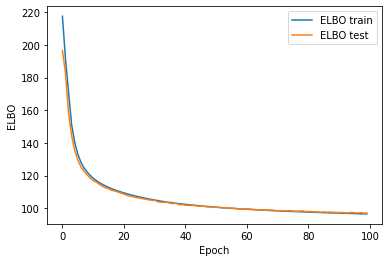

Wall time: 20min 23s


In [85]:
%%time
seed_everything()
pyro.clear_param_store()

loaders = MNIST_loaders
test_batch_x = MNIST_test_batch_x
ssvae = SSVAE(z_dim=50, hidden_dims=[200, 400], device=device)
train_SSVAE(loaders, ssvae, device=device, epochs=100, nth_supervised=2)

In [86]:
def ssvae_reconstruct_imgs(ssvae, x, y):
    y = F.one_hot(y, ssvae.output_size)
    x = x.reshape(-1, ssvae.input_size)
    z_loc, z_scale = ssvae.encoder_z(ssvae.concat(x, y))
    z = dist.Normal(z_loc, z_scale).sample() # sample in latent space
    loc_img = ssvae.decoder(torch.cat([z, y], dim=-1))
    return loc_img

Original Batch


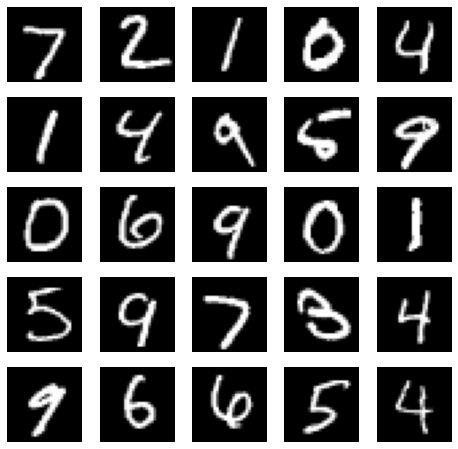

Reconstructed Batch


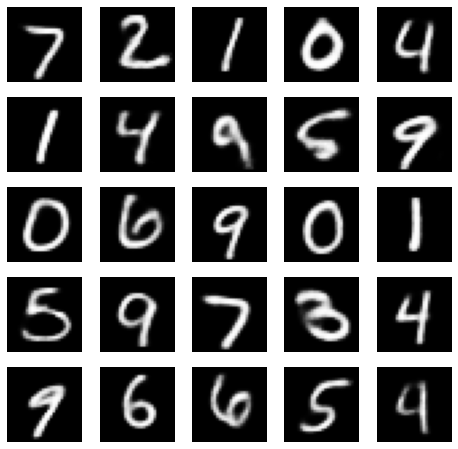

In [87]:
print('Original Batch')
plot_batch(test_batch_x.cpu(),figsize=(8, 8))
print('Reconstructed Batch')
reconstruced_x = ssvae_reconstruct_imgs(ssvae, test_batch_x, test_batch_y)
plot_batch(reconstruced_x.cpu().detach().numpy().reshape((26, 1, 28, 28)), figsize=(8, 8))

In [88]:
def ssvae_sample_imgs(ssvae, n, y, device):
    y = F.one_hot(y, ssvae.output_size)

    z_loc = torch.zeros(n, ssvae.z_dim, device=device)
    z_scale = torch.ones(n, ssvae.z_dim, device=device)
    
    z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    imgs = ssvae.decoder(torch.cat([z, y], dim=-1))
    return imgs

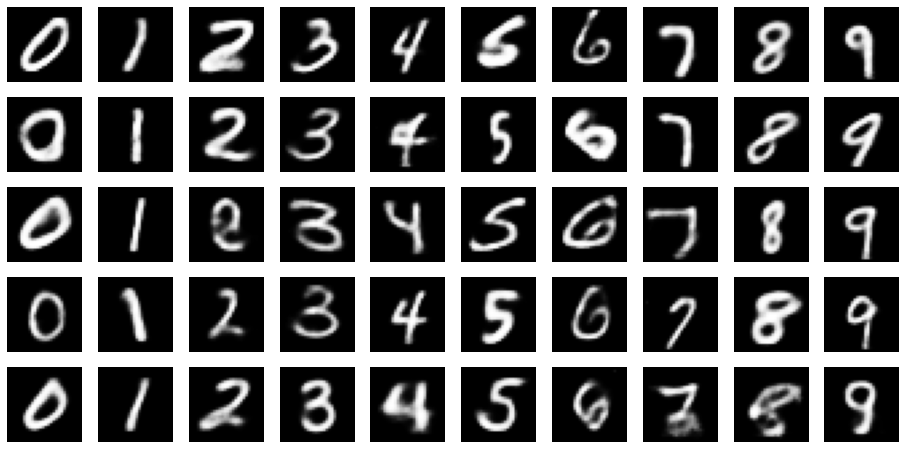

In [89]:
N = 50
selected_y = torch.tensor([i % 10 for i in range(50)]).to(device)
sampled_x = ssvae_sample_imgs(ssvae, N, selected_y, device)
plot_batch(sampled_x.cpu().detach().numpy().reshape((N, 1, 28, 28)), rows=5, cols=10, figsize=(16, 8))